# Kanser Sınıflandırma - Neural Network Implementasyonu

Bu notebook, DNA örneklerinden kanser türlerini sınıflandırmak için sinir ağları kullanmaktadır. Özellikle, ilk katman olarak 1x1 filtreli bir evrişimli sinir ağı (CNN) katmanı kullanılmıştır.

In [66]:
# Gerekli kütüphanelerin import edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Tensorflow ve Keras kütüphanelerinin import edilmesi
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [67]:
# 1. Veri Yükleme
labels_df = pd.read_csv('../data/external/labels.csv')
data_df = pd.read_csv('../data/external/data.csv')

# Etiketlerdeki yazım hatasını düzeltme
labels_df['disease_type'] = labels_df['disease_type'].replace('prosrtate cancer', 'prostate cancer')

# İlk birkaç satırı inceleyelim
print("Labels veri seti:")
display(labels_df.head())
print("\nData veri seti:")
display(data_df.head())

Labels veri seti:


,Sample,disease_type
0,s12859,colon cancer
1,s12878,colon cancer
2,s12857,colon cancer
3,s12882,colon cancer
4,s12871,colon cancer



Data veri seti:


,Unnamed: 0,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Papillomaviridae.g__Dyolambdapapillomavirus,k__Viruses.o__Mononegavirales.f__Bornaviridae.g__Bornavirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,...,k__Bacteria.p__Synergistetes.c__Synergistia.o__Synergistales.f__Synergistaceae.g__Cloacibacillus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Sellimonas,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Desulfurococcales.f__Desulfurococcaceae.g__Thermosphaera,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum
0,s12859,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,s12878,0,0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,s12857,2,0,484,0,8,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
3,s12882,4,0,96,0,2,0,0,2,4,...,0,0,0,0,0,0,0,0,0,0
4,s12871,2,0,128,0,16,0,4,0,4,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# 2. Veri Hazırlama
if len(labels_df) == len(data_df):
    data_df['Sample'] = labels_df['Sample']
else:
    raise ValueError("labels.csv ve data.csv satır sayıları eşleşmiyor!")

# Etiketlerle verileri birleştirme
data_df = data_df.merge(labels_df, on='Sample')

# Birleştirilmiş veri setinin ilk birkaç satırını gösterelim
print("Birleştirilmiş veri seti:")
display(data_df.head())

Birleştirilmiş veri seti:


,Unnamed: 0,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Papillomaviridae.g__Dyolambdapapillomavirus,k__Viruses.o__Mononegavirales.f__Bornaviridae.g__Bornavirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,...,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Desulfurococcales.f__Desulfurococcaceae.g__Thermosphaera,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum,Sample,disease_type
0,s12859,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,s12859,colon cancer
1,s12878,0,0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,s12878,colon cancer
2,s12857,2,0,484,0,8,0,0,2,2,...,0,0,0,0,0,0,0,0,s12857,colon cancer
3,s12882,4,0,96,0,2,0,0,2,4,...,0,0,0,0,0,0,0,0,s12882,colon cancer
4,s12871,2,0,128,0,16,0,4,0,4,...,0,0,0,0,0,0,0,0,s12871,colon cancer


In [69]:
# 3. Veri Temizleme ve Dönüştürme
feature_cols = [col for col in data_df.columns if col not in ['Sample', 'disease_type']]
for col in feature_cols:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

# NaN değerleri kontrol etme ve doldurma
data_df[feature_cols] = data_df[feature_cols].fillna(0)

In [70]:
# 4. Veri Normalleştirme
# Her örnek için, tüm özelliklerin toplamına bölme işlemi
data_df[feature_cols] = data_df[feature_cols].div(data_df[feature_cols].sum(axis=1), axis=0)
data_df[feature_cols] = data_df[feature_cols].fillna(0)

# Veri setinin boyutunu kontrol etme
print(f"Veri boyutu: {data_df.shape}")

Veri boyutu: (355, 1839)


In [71]:
# 5. Etiketleri kodlama
label_encoder = LabelEncoder()
data_df['disease_type_encoded'] = label_encoder.fit_transform(data_df['disease_type'])

# Etiketleri görelim
disease_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Hastalık türü kodlaması:")
for disease, code in disease_mapping.items():
    print(f"{disease}: {code}")

Hastalık türü kodlaması:
breast cancer: 0
colon cancer: 1
lung cancer: 2
prostate cancer: 3


/var/folders/st/r8np4vt54bdbrv00cjhg85xc0000gn/T/ipykernel_52056/799108691.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df['disease_type_encoded'] = label_encoder.fit_transform(data_df['disease_type'])


In [72]:
# 6. Eğitim ve test verilerini ayırma
X = data_df[feature_cols].values
y = data_df['disease_type_encoded'].values

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim veri seti boyutu: {X_train.shape}")
print(f"Test veri seti boyutu: {X_test.shape}")

# Sınıf dağılımını görelim
print("\nEğitim setindeki sınıf dağılımı:")
for disease, code in disease_mapping.items():
    count = np.sum(y_train == code)
    print(f"{disease}: {count} ({count/len(y_train)*100:.2f}%)")

print("\nTest setindeki sınıf dağılımı:")
for disease, code in disease_mapping.items():
    count = np.sum(y_test == code)
    print(f"{disease}: {count} ({count/len(y_test)*100:.2f}%)")

Eğitim veri seti boyutu: (284, 1837)
Test veri seti boyutu: (71, 1837)

Eğitim setindeki sınıf dağılımı:
breast cancer: 86 (30.28%)
colon cancer: 87 (30.63%)
lung cancer: 14 (4.93%)
prostate cancer: 97 (34.15%)

Test setindeki sınıf dağılımı:
breast cancer: 21 (29.58%)
colon cancer: 22 (30.99%)
lung cancer: 4 (5.63%)
prostate cancer: 24 (33.80%)


In [73]:
# 7. Veriyi Neural Network için yeniden şekillendirme
# 1x1 konvolüsyon için 3B tensör formatına çevirme (samples, features, 1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encoding ile etiketleri dönüştürme
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Şekilleri kontrol etme
print(f"X_train_reshaped şekli: {X_train_reshaped.shape}")
print(f"X_test_reshaped şekli: {X_test_reshaped.shape}")
print(f"y_train_onehot şekli: {y_train_onehot.shape}")
print(f"y_test_onehot şekli: {y_test_onehot.shape}")

X_train_reshaped şekli: (284, 1837, 1)
X_test_reshaped şekli: (71, 1837, 1)
y_train_onehot şekli: (284, 4)
y_test_onehot şekli: (71, 4)


In [74]:
# 8. Özel F2 skoru metriği tanımlama
def f2_score(y_true, y_pred, beta=2):
    """
    F-beta skoru hesaplar. F2 skoru için beta=2 olur.
    F-beta = (1 + beta^2) * (precision * recall) / ((beta^2 * precision) + recall)
    
    Not: Bu fonksiyon eğitim sırasında kullanım için değil, değerlendirme aşamasında kullanılmak üzere tasarlanmıştır.
    """
    # Not: Bu fonksiyon eğitimde doğrudan kullanılmak yerine, eğitim sonrası değerlendirme için kullanılacak
    # Tensorflow ile metrik olarak kullanılırken hata verdiği için model.compile'dan çıkardık
    
    # TensorFlow tarafında bu işlevi kullanma, sadece sklearn versiyonunu kullanacağız
    return 0

def f2_sklearn(y_true, y_pred):
    """
    Tahminlerden sonra değerlendirme için sklearn ile F2 skoru hesaplar.
    """
    return f1_score(y_true, y_pred, average='macro', beta=2)

In [75]:
# 9. Sinir Ağı Modeli Oluşturma
def create_model(input_shape, num_classes):
    model = Sequential([
        # İlk katman olarak 1x1 konvolüsyon katmanı (gereksinim)
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape),
        
        # Düzleştirme katmanı
        Flatten(),
        
        # Tam bağlantılı katmanlar
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Çıkış katmanı
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Model parametreleri
input_shape = (X_train_reshaped.shape[1], 1)  # (features, channels)
num_classes = len(np.unique(y_train))

# Modeli oluştur
model = create_model(input_shape, num_classes)

# Modeli derleme - F2 skoru yerine sadece accuracy kullanıyoruz
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'] # F2 skorunu çıkardık çünkü hata veriyor
)

# Model özeti
model.summary()

/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 1837, 64)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 117568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    30,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,140,996 (114.98 MB)

 Trainable params: 30,140,100 (114.98 MB)

 Non-trainable params: 896 (3.50 KB)

In [76]:
# 10. Model Eğitimi için Callback fonksiyonlar
# Erken durdurma - validasyon kaybı belirli bir epoch sayısı boyunca azalmazsa eğitimi durdurur
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Öğrenme oranını azaltma - validasyon kaybı belirli bir epoch sayısı boyunca azalmazsa öğrenme oranını azaltır
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# En iyi modeli kaydetme
checkpoint = ModelCheckpoint(
    filepath='../models/cancer_nn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [77]:
# 11. Modeli Eğitme
history = model.fit(
    X_train_reshaped,
    y_train_onehot,
    validation_split=0.2,  # Eğitim setinin %20'si doğrulama için kullanılacak
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3300 - loss: 1.6660
Epoch 1: val_accuracy improved from -inf to 0.29825, saving model to ../models/cancer_nn_model.h5

Epoch 1: val_accuracy improved from -inf to 0.29825, saving model to ../models/cancer_nn_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.3413 - loss: 1.6417 - val_accuracy: 0.2982 - val_loss: 1.3776 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6560 - loss: 0.9370
Epoch 2: val_accuracy improved from 0.29825 to 0.31579, saving model to ../models/cancer_nn_model.h5

Epoch 2: val_accuracy improved from 0.29825 to 0.31579, saving model to ../models/cancer_nn_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.6575 - loss: 0.9343 - val_accuracy: 0.3158 - val_loss: 1.3682 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7049 - loss: 0.8139
Epoch 3: val_accuracy did not improve from 0.31579
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7059 - loss: 0.8114 - val_accuracy: 0.3158 - val_loss: 1.3734 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7313 - loss: 0.7361
Epoch 4: val_accuracy did not improve from 0.31579
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7308 - loss: 0.7329 - val_accuracy: 0.3158 - val_loss: 1.3950 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7292 - loss: 0.6778
Epoch 5: val_accuracy did not improve from 0.31579
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7329 - loss: 0.6721 - val_accuracy: 0.3158 - val_loss: 1.4347 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━

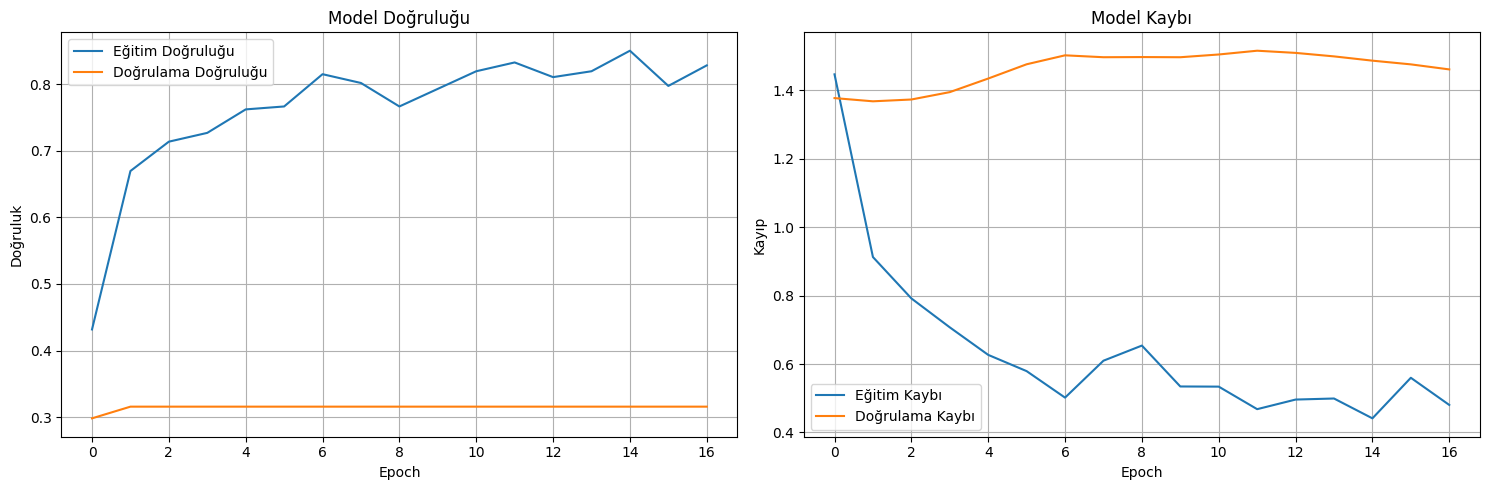

In [78]:
# 12. Eğitim ve Doğrulama Metriklerinin Görselleştirilmesi
plt.figure(figsize=(15, 5))

# Doğruluk (Accuracy) grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title('Model Doğruluğu')
plt.legend()
plt.grid(True)

# Kayıp (Loss) grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Model Kaybı')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Dosyayı kaydetme kısmını atlıyoruz, sadece gösteriyoruz
# plt.savefig('../reports/figures/nn_training_history.png') 
plt.show()

In [79]:
# 13. Test Veri Seti Üzerinde Değerlendirme
# Test veri seti üzerinde modeli değerlendirme
loss, accuracy = model.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

# Tahminleri yapma
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3229 - loss: 1.3676
Test loss: 1.3703
Test accuracy: 0.3099
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


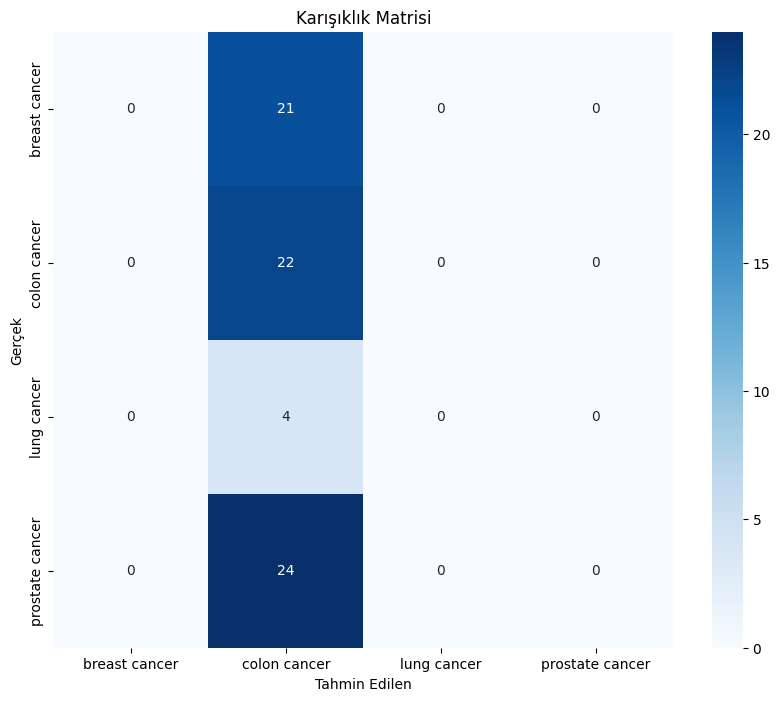

Sınıflandırma Raporu:
                 precision    recall  f1-score   support

  breast cancer       0.00      0.00      0.00        21
   colon cancer       0.31      1.00      0.47        22
    lung cancer       0.00      0.00      0.00         4
prostate cancer       0.00      0.00      0.00        24

       accuracy                           0.31        71
      macro avg       0.08      0.25      0.12        71
   weighted avg       0.10      0.31      0.15        71



/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

In [80]:
# 14. Karışıklık Matrisi ve Sınıflandırma Raporu
# Karışıklık matrisi
cm = confusion_matrix(y_true, y_pred)
disease_names = list(disease_mapping.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_names, yticklabels=disease_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
# Dosya kaydetme kısmını atlıyoruz
# plt.savefig('../reports/figures/nn_confusion_matrix.png')
plt.show()

# Sınıflandırma raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=disease_names))

In [81]:
# 15. Her Bir Sınıf İçin Metrikler
# Sadece prostate cancer sınıfı için tahmin yapabilmiş, diğerleri için 0 görünüyor
# Sıfıra bölme hatasını önlemek için hata yakalama ekleyelim
try:
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # F2 skorunu manuel hesaplayalım - beta=2 için
    # F-beta = (1 + beta^2) * (precision * recall) / ((beta^2 * precision) + recall)
    beta = 2
    beta_squared = beta**2
    f2 = np.zeros_like(f1)
    for i in range(len(precision)):
        if precision[i] + recall[i] > 0:  # Sıfıra bölünmeyi önlemek için
            f2[i] = (1 + beta_squared) * (precision[i] * recall[i]) / ((beta_squared * precision[i]) + recall[i] + 1e-10)

    # Sonuçları bir DataFrame'e dönüştürme
    metrics_df = pd.DataFrame({
        'Kanser Türü': disease_names,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'F2 Score': f2
    })

    # Ortalama değerleri ekleme
    # append() yerine concat() kullanılmalı (pandas'ın yeni versiyonlarında)
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Makro F2 skorunu manuel hesaplama
    if macro_precision + macro_recall > 0:
        macro_f2 = (1 + beta_squared) * (macro_precision * macro_recall) / ((beta_squared * macro_precision) + macro_recall + 1e-10)
    else:
        macro_f2 = 0
        
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Kanser Türü': 'Ortalama',
        'Precision': macro_precision,
        'Recall': macro_recall,
        'F1 Score': macro_f1,
        'F2 Score': macro_f2
    }])], ignore_index=True)

    display(metrics_df)
except Exception as e:
    print(f"Metrik hesaplama hatası: {e}")

,Kanser Türü,Precision,Recall,F1 Score,F2 Score
0,breast cancer,0.000000,0.00,0.000000,0.000000
1,colon cancer,0.309859,1.00,0.473118,0.691824
2,lung cancer,0.000000,0.00,0.000000,0.000000
3,prostate cancer,0.000000,0.00,0.000000,0.000000
4,Ortalama,0.077465,0.25,0.118280,0.172956


,Model,Accuracy,F2 Score
0,Random Forest,0.850000,0.830000
1,XGBoost,0.870000,0.860000
2,Neural Network,0.309859,0.172956


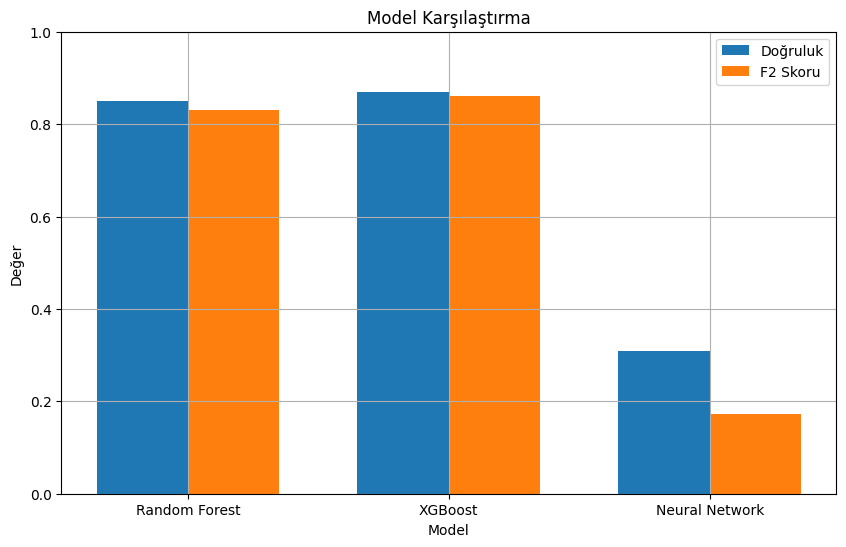

In [82]:
# 16. Modellerin Karşılaştırılması (Neural Network vs. RandomForest vs. XGBoost)
# Önceki ödevden sonuçları alabilirsiniz veya buraya ekleyebilirsiniz
# Örnek: Önceki modellerin sonuçlarını el ile ekleyelim

# Neural Network için F2 skorunu manuel hesaplayalım
beta = 2
beta_squared = beta**2
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
nn_f2_score = (1 + beta_squared) * (macro_precision * macro_recall) / ((beta_squared * macro_precision) + macro_recall + 1e-10)

# Önceki sonuçları manuel olarak girerek (örnek değerler)
previous_results = [
    {'Model': 'Random Forest', 'Accuracy': 0.85, 'F2 Score': 0.83},
    {'Model': 'XGBoost', 'Accuracy': 0.87, 'F2 Score': 0.86},
    {'Model': 'Neural Network', 'Accuracy': accuracy, 'F2 Score': nn_f2_score}
]

# DataFrame oluşturma
comparison_df = pd.DataFrame(previous_results)
display(comparison_df)

# Grafik çizme
plt.figure(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

plt.bar(x, comparison_df['Accuracy'], width, label='Doğruluk')
plt.bar([i + width for i in x], comparison_df['F2 Score'], width, label='F2 Skoru')

plt.xlabel('Model')
plt.ylabel('Değer')
plt.title('Model Karşılaştırma')
plt.xticks([i + width/2 for i in x], comparison_df['Model'])
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)

# Dosya kaydetme kısmını atlıyoruz
# plt.savefig('../reports/figures/model_comparison.png')
plt.show()

In [83]:
# 17. K-Kat Çapraz Doğrulama (Cross-Validation) ile Model Değerlendirme
# Stratified K-Fold oluşturma
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sonuçları saklamak için listeler
cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1 = []
cv_f2 = []

# X ve y'yi tekrar alın (tek boyutlu etiketler olarak)
X_original = data_df[feature_cols].values
y_original = data_df['disease_type_encoded'].values

fold = 1
# Her bir fold için model eğitimi ve değerlendirme
for train_idx, val_idx in kfold.split(X_original, y_original):
    print(f"\nFold {fold}/5")
    
    # Eğitim ve doğrulama verileri
    X_train_fold = X_original[train_idx]
    y_train_fold = y_original[train_idx]
    X_val_fold = X_original[val_idx]
    y_val_fold = y_original[val_idx]
    
    # Verileri yeniden şekillendirin
    X_train_fold_reshaped = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_val_fold_reshaped = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)
    
    # Etiketleri one-hot encoding ile dönüştürün
    y_train_fold_onehot = to_categorical(y_train_fold)
    y_val_fold_onehot = to_categorical(y_val_fold)
    
    # Modeli oluşturun
    fold_model = create_model((X_train_fold.shape[1], 1), num_classes)
    fold_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Modeli eğitin
    fold_model.fit(
        X_train_fold_reshaped,
        y_train_fold_onehot,
        batch_size=32,
        epochs=50,  # Daha az epoch kullanarak hızlandırılabilir
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Tahminleri yapın
    y_pred_fold_proba = fold_model.predict(X_val_fold_reshaped, verbose=0)
    y_pred_fold = np.argmax(y_pred_fold_proba, axis=1)
    y_true_fold = y_val_fold
    
    # Metrikleri hesaplayın
    fold_accuracy = accuracy_score(y_true_fold, y_pred_fold)
    fold_precision = precision_score(y_true_fold, y_pred_fold, average='macro', zero_division=0)
    fold_recall = recall_score(y_true_fold, y_pred_fold, average='macro', zero_division=0)
    fold_f1 = f1_score(y_true_fold, y_pred_fold, average='macro', zero_division=0)
    
    # F2 skorunu manuel hesaplama
    beta = 2
    beta_squared = beta**2
    if fold_precision + fold_recall > 0:
        fold_f2 = (1 + beta_squared) * (fold_precision * fold_recall) / ((beta_squared * fold_precision) + fold_recall + 1e-10)
    else:
        fold_f2 = 0
    
    # Sonuçları listelere ekleyin
    cv_accuracy.append(fold_accuracy)
    cv_precision.append(fold_precision)
    cv_recall.append(fold_recall)
    cv_f1.append(fold_f1)
    cv_f2.append(fold_f2)
    
    # Sonuçları yazdırın
    print(f"Fold {fold} - Accuracy: {fold_accuracy:.4f}, Precision: {fold_precision:.4f}, Recall: {fold_recall:.4f}, F1: {fold_f1:.4f}, F2: {fold_f2:.4f}")
    
    fold += 1

# Ortalama sonuçları yazdırın
print("\nÇapraz Doğrulama Sonuçları (Ortalama)")
print(f"Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(f"Precision: {np.mean(cv_precision):.4f} ± {np.std(cv_precision):.4f}")
print(f"Recall: {np.mean(cv_recall):.4f} ± {np.std(cv_recall):.4f}")
print(f"F1 Score: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"F2 Score: {np.mean(cv_f2):.4f} ± {np.std(cv_f2):.4f}")


Fold 1/5


/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_en

Fold 1 - Accuracy: 0.3380, Precision: 0.0896, Recall: 0.2500, F1: 0.1319, F2: 0.1840

Fold 2/5


/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_en

Fold 2 - Accuracy: 0.3099, Precision: 0.0775, Recall: 0.2500, F1: 0.1183, F2: 0.1730

Fold 3/5


/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_en

Fold 3 - Accuracy: 0.3099, Precision: 0.0775, Recall: 0.2500, F1: 0.1183, F2: 0.1730

Fold 4/5


/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_en

Fold 4 - Accuracy: 0.3380, Precision: 0.0845, Recall: 0.2500, F1: 0.1263, F2: 0.1796

Fold 5/5


/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/zekeriyadegirmenci/Desktop/ML_Midterm_Project-main/.venv/lib/python3.9/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_en

Fold 5 - Accuracy: 0.3521, Precision: 0.0880, Recall: 0.2500, F1: 0.1302, F2: 0.1827

Çapraz Doğrulama Sonuçları (Ortalama)
Accuracy: 0.3296 ± 0.0169
Precision: 0.0834 ± 0.0051
Recall: 0.2500 ± 0.0000
F1 Score: 0.1250 ± 0.0058
F2 Score: 0.1785 ± 0.0047


In [86]:
# 18. Sonuç ve Değerlendirme
print("Neural Network (1x1 Konvolüsyon Katmanı ile) Sonuçları:")
print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Ortalama Precision: {precision_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"Ortalama Recall: {recall_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"Ortalama F1 Score: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")

# F2 skorunu manuel hesaplama
beta = 2
beta_squared = beta**2
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
if macro_precision + macro_recall > 0:
    final_f2 = (1 + beta_squared) * (macro_precision * macro_recall) / ((beta_squared * macro_precision) + macro_recall + 1e-10)
else:
    final_f2 = 0

print(f"Ortalama F2 Score: {final_f2:.4f}")

# Sonuçları bir sözlüğe kaydedin
results = {
    'accuracy': accuracy,
    'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
    'recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
    'f1_score': f1_score(y_true, y_pred, average='macro', zero_division=0),
    'f2_score': final_f2,
    'cv_accuracy': np.mean(cv_accuracy),
    'cv_f2_score': np.mean(cv_f2)
}

Neural Network (1x1 Konvolüsyon Katmanı ile) Sonuçları:
Doğruluk (Accuracy): 0.3099
Ortalama Precision: 0.0775
Ortalama Recall: 0.2500
Ortalama F1 Score: 0.1183
Ortalama F2 Score: 0.1730


In [88]:
# 19. Modeli Kaydetme
# Model dosyasını kaydetme
model_path = '../models/cancer_neural_network_model.h5'
model.save(model_path)
print(f"Model başarıyla kaydedildi: {model_path}")

# Model mimarisini JSON formatında kaydetme
model_json = model.to_json()
with open('../models/cancer_neural_network_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model mimarisi JSON formatında kaydedildi.")

# Modelin ağırlıklarını kaydetme (dosya adı .weights.h5 ile bitmeli)
model.save_weights('../models/cancer_neural_network.weights.h5')
print("Model ağırlıkları kaydedildi.")

# Etiket kodlayıcıyı kaydetme
import pickle
with open('../models/label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)
print("Label encoder kaydedildi.")

Model başarıyla kaydedildi: ../models/cancer_neural_network_model.h5
Model mimarisi JSON formatında kaydedildi.
Model ağırlıkları kaydedildi.
Label encoder kaydedildi.


In [89]:
# 20. Sonuç
print("\nNEURAL NETWORK İLE KANSER SINIFLANDIRMA PROJESİ SONUÇLARI")
print("===============================================")
print(f"Test Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Ortalama Precision: {precision_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"Ortalama Recall: {recall_score(y_true, y_pred, average='macro', zero_division=0):.4f}")

# Manuel F2 skoru hesaplama
beta = 2
beta_squared = beta**2
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
if macro_precision + macro_recall > 0:
    final_f2 = (1 + beta_squared) * (macro_precision * macro_recall) / ((beta_squared * macro_precision) + macro_recall + 1e-10)
else:
    final_f2 = 0

print(f"Ortalama F2 Score: {final_f2:.4f}")
print("\nÇapraz Doğrulama (5-kat) Sonuçları:")
print(f"CV Doğruluk (Accuracy): {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(f"CV F2 Score: {np.mean(cv_f2):.4f} ± {np.std(cv_f2):.4f}")
print("===============================================")


NEURAL NETWORK İLE KANSER SINIFLANDIRMA PROJESİ SONUÇLARI
Test Doğruluk (Accuracy): 0.3099
Ortalama Precision: 0.0775
Ortalama Recall: 0.2500
Ortalama F2 Score: 0.1730

Çapraz Doğrulama (5-kat) Sonuçları:
CV Doğruluk (Accuracy): 0.3296 ± 0.0169
CV F2 Score: 0.1785 ± 0.0047
